# Analiza pogrzebów

Dobrych parę lat temu zmagaliśmy się z pandemią COVID 19. Kolejne obostrzenia, niepokojące wydarzenia i zwykła ciekawość prowadziły do zwiększonego zainteresowania wykresami zachorowań i zgonów. Sam poszukiwałem sensownych i ciekawych statystyk.
Najczęściej zaglądałem na stronę [koronawirusunas.pl](https://koronawirusunas.pl/), ponieważ znajdują się tam wyniki dla całego kraju w jednym miejscu.
Wykresy przedstawiające zachorowania na COVID19:
- są to wyniki testów, różna dostępność, uznaniowość, jakość testów
- okresowość wynikająca z działania systemu i laboratoriów, a przecież zachorowania nie znają tygodniowej sezonowości
- czasami zdarzały się aktualizacje historycznych danych

Zgony:
- występują z opóźnieniem względem zachorowań
- pewna uznaniowość (kwestia definicji), czy dany zgon kwalifikuje się jako covidowy
- czasami dane spływały dłużej i były aktualizowane (podobnie jak zachorowań)

Statystyki krajowe [stats gov](https://stat.gov.pl/obszary-tematyczne/ludnosc/ludnosc/zgony-wedlug-tygodni-oraz-wieku-plci-zmarlych-i-73-podregionow-w-2023-roku,39,24.html):
- trudny format do obróbki danych
- rozdzielczość tygodniowa z opóźnioną publikacją

Dla innych europejskich krajów są choćby dane dostępne na stronie [EuroMOMO](https://www.euromomo.eu/graphs-and-maps). Nadwyżki zgonów i kategorie wiekowe są tam ładnie zwizualizowane. Dane pojawiają się w miarę na bieżąco w rozdzielczości tygodniowej, ale trzeba pamiętać, że mogą być wstecznie poprawiane (jak każde dane w czasie, które napływają z raportów).

Poszukując innych źródeł sprawdzonych danych natrafiłem na stronę [cmentarzy komunalnych w Krakowie](https://zck-krakow.pl/funerals). Dane o pogrzebach są publikowane przed pogrzebem i można również przejrzeć historię na kilka lat. Dla dość dużego miasta jakim jest Kraków codziennie pojawia się kilkanaście wpisów, co stanowi wystarczającą dużó do przeprowadzenia ciekawych analiz. Poza samym faktem zaistnienia pogrzebu dostajemy również informację o wieku zmarłego i płci (z imienia i nazwiska). To pozwala uzyskać interesujące wykresy.

Informacje o pochówkach:
- dość aktualne dane o zgonach (aczkolwiek zebranie pochówków dodanych danego dnia wymaga wiecej pracy, w szczególności zbierania danych na bieżąco)
- dość dokładne dane (imię, nazwisko, wiek)
- dane historyczne raczej nie ulegają zmianom - tak wynika z moich obserwacji
- czasem zdażą się błędy - głównie _litrówki_

In [1]:
import pandas as pd
import pylab as plt
import matplotlib.dates as mdates

In [2]:
df = pd.read_csv("dane_zck.csv",index_col = 0)
df.index = pd.to_datetime(df.index)
dfAge = pd.read_csv("age_gender.csv", index_col = 0)
dfAge.datum = pd.to_datetime(dfAge.datum)

In [3]:
count = (df.groupby(df.index.year).mean()*365).map(lambda x: f"{x:.1f}")
count = count.reset_index().rename(columns = {"datum":"rok", "person": "pogrzeby (średnia)"}).set_index("rok").map(lambda x: float(x))

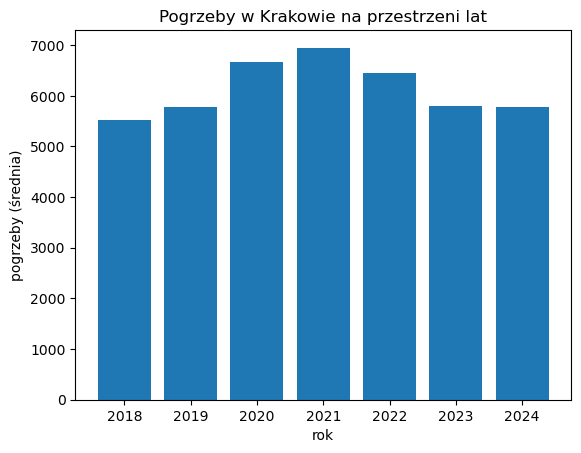

In [4]:
plt.title("Pogrzeby w Krakowie na przestrzeni lat")
plt.bar(count.index.to_numpy(), count["pogrzeby (średnia)"].to_numpy())
plt.xlabel('rok')
plt.ylabel("pogrzeby (średnia)");

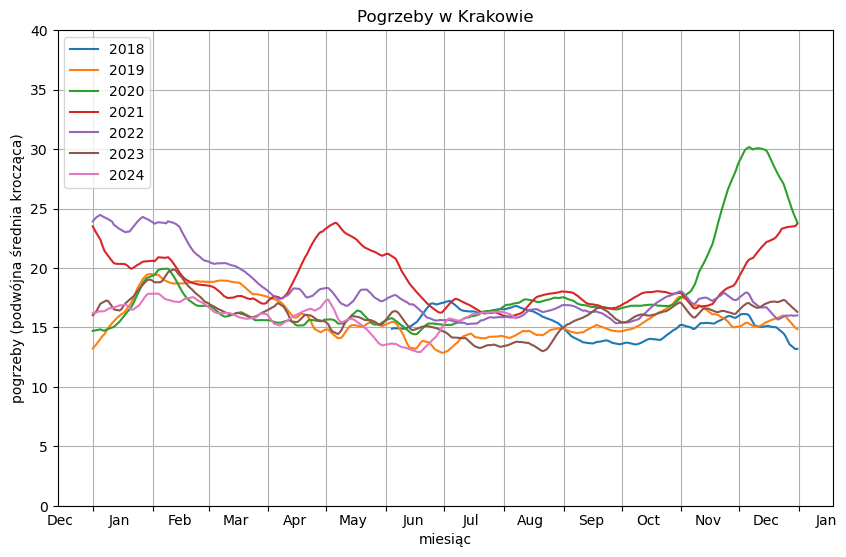

In [5]:
fig = plt.figure(figsize=(10,10/1.618))
ax = fig.add_subplot(111)
ax.tick_params(axis='x', which='minor') 

for dd in df.rolling(window = 7).mean().rolling(window = 28).mean().groupby(df.index.year):
    DF = dd[1]
    DF.index = DF.index.map(lambda x: x - pd.DateOffset(year=2000))
    plt.plot(DF.person, label = dd[0])

ax.xaxis.set_major_formatter(mdates.DateFormatter(''))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
ax.tick_params(which='minor',width=0)
plt.legend()
plt.title("Pogrzeby w Krakowie")
plt.xlabel('miesiąc')
plt.ylabel('pogrzeby (podwójna średnia krocząca)')
plt.ylim([0,40])
plt.grid();

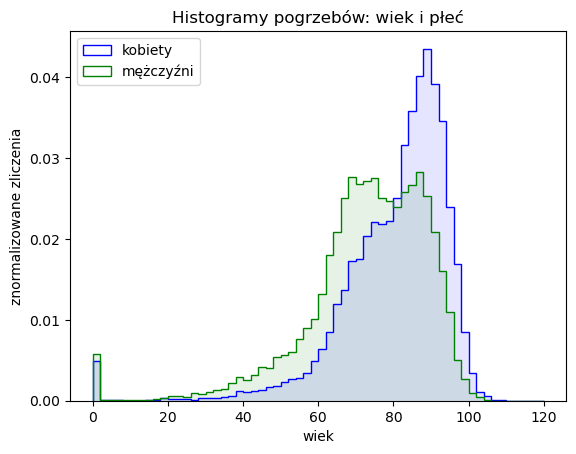

In [6]:
plt.hist(dfAge[dfAge.female==True ].age,range = (0,120),bins = 60, histtype="step", density=True, color = 'blue', label='kobiety');
plt.hist(dfAge[dfAge.female==False ].age,range = (0,120),bins = 60, histtype="step", density=True, color = 'green',label = "mężczyźni");
plt.hist(dfAge[dfAge.female==True ].age,range = (0,120),bins = 60, histtype="stepfilled", density=True, color = 'blue',  alpha=0.1);
plt.hist(dfAge[dfAge.female==False ].age,range = (0,120),bins = 60, histtype="stepfilled", density=True, color = 'green', alpha=0.1);
plt.title("Histogramy pogrzebów: wiek i płeć")
plt.xlabel("wiek")
plt.ylabel("znormalizowane zliczenia")
plt.legend();

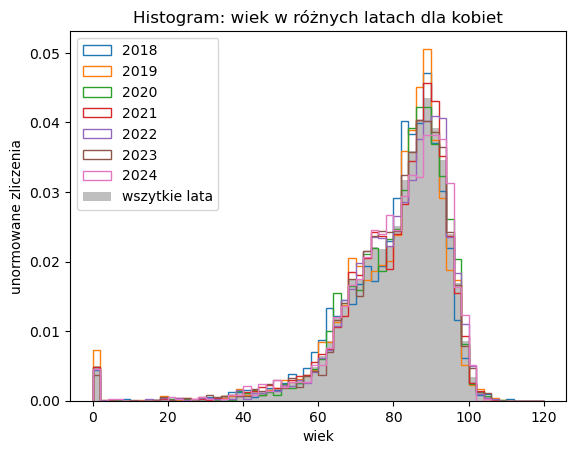

In [7]:
for year in range(2018,2024+1):
    plt.hist(dfAge[(dfAge.female==True) & dfAge.datum.apply(lambda x: x.year==year)].age,range = (0,120),bins = 60, histtype="step",label=year, density=True);
plt.hist(dfAge[(dfAge.female==True) ].age,range = (0,120),bins = 60, histtype="stepfilled",color='grey', alpha = 0.5, label = 'wszytkie lata', density=True);
plt.legend();
plt.title("Histogram: wiek w różnych latach dla kobiet")
plt.xlabel("wiek")
plt.ylabel("unormowane zliczenia");

In [8]:
(dfAge.female==True).sum()/dfAge.female.count()

0.5196872596770059

In [9]:
import scipy.stats as ss

In [10]:
ss.ttest_1samp(dfAge.female, 0.517)

TtestResult(statistic=1.0623288009230685, pvalue=0.2880930203696596, df=39009)

In [11]:
deaths = 414_000
births = 388_000
perc = 0.0038

In [12]:
poland = perc*births/deaths

In [13]:
krk = (dfAge.age<1.0).mean()

In [14]:
krk/poland

2.936765243632314